In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [12]:

train_dir = 'chest_xray/train'
validation_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Using ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [15]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
class_weights = {0: 1.0, 1: 2.0}  # Weighting the pneumonia class higher

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weights
)


c:\Users\MolenGeek\Documents\projet_pneu\.conda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
163/163 [==============================] - 221s 1s/step - loss: 0.3742 - accuracy: 0.8781 - val_loss: 0.2695 - val_accuracy: 0.9375
Epoch 2/5
163/163 [==============================] - 217s 1s/step - loss: 0.2501 - accuracy: 0.9285 - val_loss: 0.3810 - val_accuracy: 0.8750
Epoch 3/5
163/163 [==============================] - 217s 1s/step - loss: 0.2039 - accuracy: 0.9383 - val_loss: 0.2038 - val_accuracy: 0.9375
Epoch 4/5
163/163 [==============================] - 217s 1s/step - loss: 0.1980 - accuracy: 0.9404 - val_loss: 0.3862 - val_accuracy: 0.8125
Epoch 5/5
163/163 [==============================] - 215s 1s/step - loss: 0.1843 - accuracy: 0.9438 - val_loss: 0.5585 - val_accuracy: 0.6875


1/1 [==============================] - 0s 164ms/step


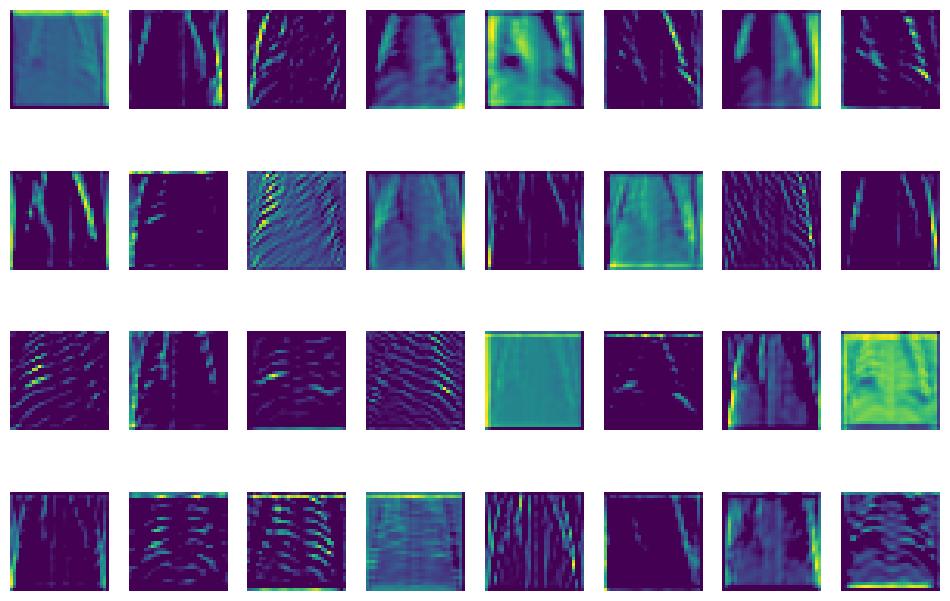

In [16]:
# Visualizing feature maps
def visualize_feature_maps(img_path):
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[5].output)
    intermediate_output = intermediate_layer_model.predict(img_array)
    
    plt.figure(figsize=(12, 8))
    for i in range(32):  # assuming 32 feature maps in the layer
        plt.subplot(4, 8, i+1)
        plt.imshow(intermediate_output[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

# Visualizing feature maps for a sample image
sample_img_path = 'chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg'
visualize_feature_maps(sample_img_path)


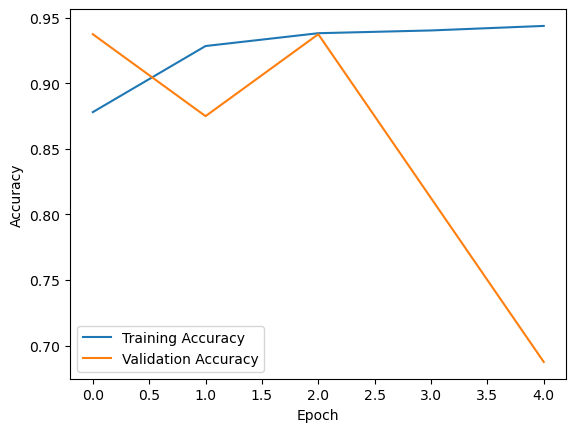

20/20 [==============================] - 25s 1s/step - loss: 0.4555 - accuracy: 0.8590
Test Accuracy: 0.8589743375778198
20/20 [==============================] - 26s 1s/step


In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Accuracy: {test_acc}')

# Get predictions
test_predictions = model.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = test_generator.classes

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(test_true_classes, test_pred_classes, target_names=class_labels))

Confusion Matrix:
[[234   0]
 [390   0]]
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



c:\Users\MolenGeek\Documents\projet_pneu\.conda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MolenGeek\Documents\projet_pneu\.conda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MolenGeek\Documents\projet_pneu\.conda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,